<h1 style=font:garmond;font-size:50px;color:orange;text-align:left>Predict ML</h1>

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from main import Lottery, Review, Timer

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Transformation</h2>

In [2]:
df = pd.read_csv('data.csv')
scaler = StandardScaler().fit(df.values)
transformed_dataset = scaler.transform(df.values)
transformed_dataframe = pd.DataFrame(data=transformed_dataset, index=df.index)

In [3]:
number_of_rows: int = df.values.shape[0]
number_of_features: int = df.values.shape[1]
window_size: int = 14

In [4]:
train = np.empty([number_of_rows-window_size, window_size, number_of_features], dtype=float)
label = np.empty([number_of_rows-window_size, number_of_features], dtype=float)

for i in range(0, number_of_rows-window_size):
    train[i]=transformed_dataframe.iloc[i:i+window_size, 0: number_of_features]
    label[i]=transformed_dataframe.iloc[i+window_size: i+window_size+1, 0: number_of_features]

# print(f'{train.shape=}\n{label.shape=}')

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Training</h2>

In [5]:
LSTM_NODES: int = 240
DENSE_LAYERS: int = 6
DROPOUT_VARIANCE: float = 0.2

In [6]:
model = Sequential()
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=False)))
model.add(Dense(DENSE_LAYERS))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])    # NOQA

In [7]:
timer = Timer()
timer.start()

batch_size: int = 28
epochs: int = 2

history = model.fit(train, label, batch_size=batch_size, epochs=epochs)

timer.stop()

Epoch 1/2
74/74 [==============================] - 13s 82ms/step - loss: 1.0149 - accuracy: 0.1632
Epoch 2/2
74/74 [==============================] - 5s 70ms/step - loss: 1.0051 - accuracy: 0.1584
Time taken: 18.325s


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Prediction</h2>


In [8]:
timer.start()

to_predict = np.array(df.iloc[-window_size:])
scaled_to_predict = scaler.transform(to_predict)

scaled_prediction = model.predict(np.array([scaled_to_predict]))
np_prediction: List[int] = scaler.inverse_transform(scaled_prediction).astype(int)[0]

print(*np_prediction, sep=', ')
timer.stop()

1/1 [==============================] - 1s 1s/step
5, 12, 18, 24, 30, 36
Time taken: 1.38s


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Result</h2>

In [9]:
prediction = list(np_prediction)
target: List[int] = Lottery(len(df)+2).collect(timer=True)

quality = Review(prediction, target)
quality.show()

Time taken: 0.358s

Prediction: 5, 12, 18, 24, 30, 36
Target: 5, 9, 14, 25, 30, 35


In [10]:
# print(f'\nPrecision = {quality.precision(show=True, percentage=False)}')

In [11]:
with open('predictions.csv', 'a', encoding='UTF-8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(np_prediction)

column_names: List[str] = ['A', 'B', 'C', 'D', 'E', 'F']
df2 = pd.read_csv('storage.csv', names=column_names)

print(df2.iloc[-6:])

    A   B   C   D   E   F
39  6  12  17  24  30  36
40  6  12  17  24  30  36
41  7  13  20  26  30  38
42  6  11  18  24  30  36
43  6  12  18  24  30  36
44  5  12  18  24  30  36


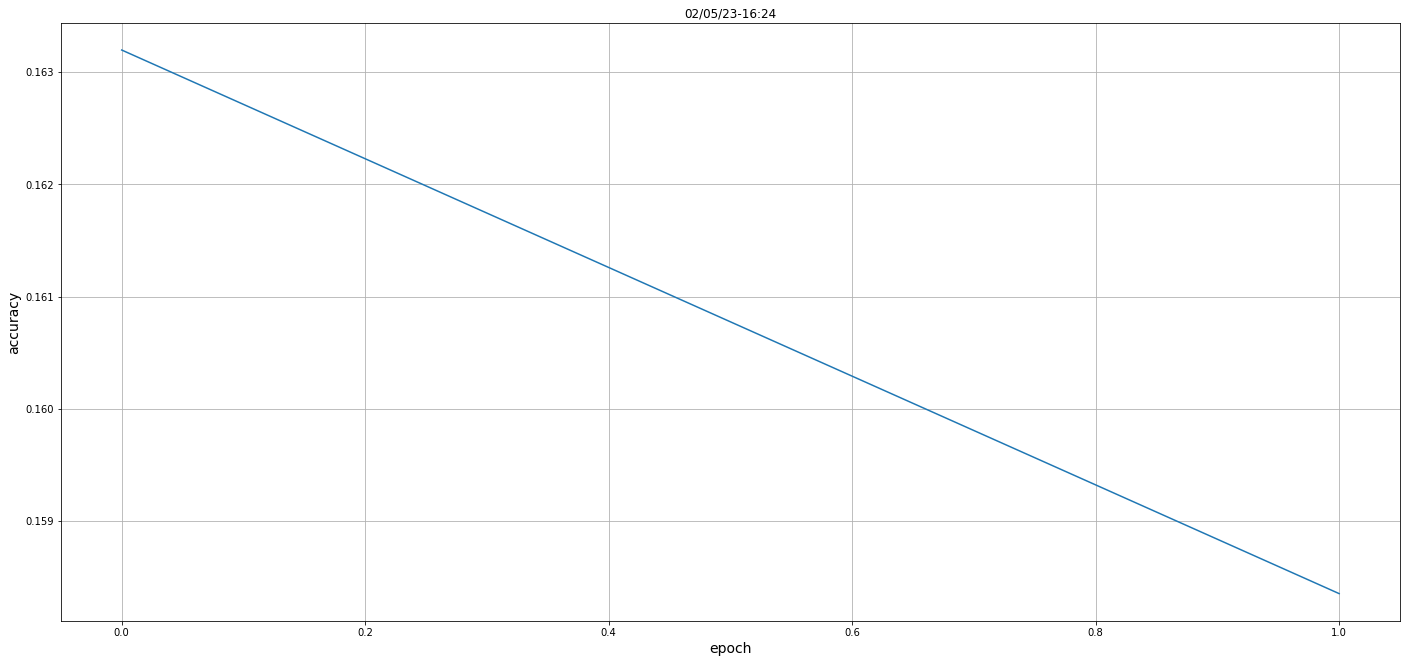

In [12]:
today: datetime = datetime.today()
now: datetime = datetime.now()

date_formatted: str = today.strftime('%m/%d/%y')
time_formatted: str = now.strftime('%H:%M')
title: str = f'{date_formatted}-{time_formatted}'

plt.figure(figsize=(24, 11))
plt.plot(history.history['accuracy'])
plt.title(title)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.grid()
plt.show()